In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

In [16]:
X = pd.read_csv("titanic.csv")
y = X['Survived'].values

In [17]:
X.drop(['PassengerId', 'Name', 'Cabin', 'Ticket','Survived'], axis=1, inplace=True)

X['Age'] = X['Age'].fillna(X['Age'].median())
X['Fare'] = X['Fare'].fillna(X['Fare'].median())
X['Embarked'] = X['Embarked'].fillna(X['Embarked'].mode())

# Age Binning
X['AgeBin'] = pd.cut(X['Age'], bins=[0, 18, 35, 60, 100], labels=[0, 1, 2, 3])
X.drop(['Age'], axis=1, inplace=True)

X = pd.get_dummies(X, columns=['Embarked','Sex','AgeBin'])


X = X.astype(float)

In [18]:
# Normalizing the features
X = (X - X.mean(axis=0)) / X.std(axis=0)

# Outlier removal based on Z-score
X = X[(X.abs() <= 3).all(axis=1)]
y = y[X.index]

In [19]:
X.shape

(736, 13)

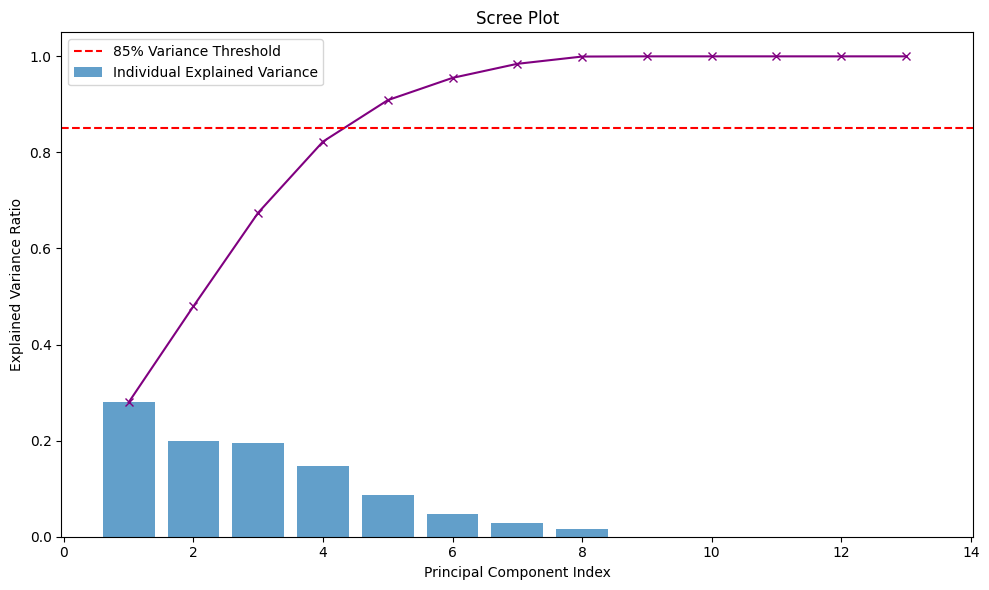

In [20]:
#PCA
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(X)  # X is the normalized dataset

# Explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

# Scree plot
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, alpha=0.7, align='center', label='Individual Explained Variance')
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, color='purple', marker = 'x')
plt.axhline(y=0.85, color='red', linestyle='--', label=f'{int(0.85 * 100)}% Variance Threshold')
plt.xlabel('Principal Component Index')
plt.ylabel('Explained Variance Ratio')
plt.title('Scree Plot')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [21]:
# Initialize PCA
n_components = 4
pca = PCA(n_components=n_components)

# Fit and transform the data
X_reduced = pca.fit_transform(X)

In [22]:
#Train Test Split
ratio = 0.8

rows = X.shape[0]
train_size = int(ratio*rows)

X_train = X_reduced[0:train_size]
X_test = X_reduced[train_size:]

y_train = y[0:train_size]
y_test = y[train_size:]

In [23]:
def hinge_loss_gradient(X, y, weights, C):
    m = len(X)
    distances = 1 - y * np.dot(X, weights)
    gradient = np.zeros(weights.shape)

    for i, d in enumerate(distances):
        if d > 0:
            gradient -= y[i] * X[i]

    gradient = weights + (C / m) * gradient
    return gradient

def train_svm(X, y, learning_rate, num_iterations, C):
    y = np.where(y == 0, -1, y)  # Convert 0 to -1 for SVM
    weights = np.zeros(X.shape[1])
    loss_history = []

    for i in range(num_iterations):
        gradient = hinge_loss_gradient(X, y, weights, C)
        weights -= learning_rate * gradient

        # Calculate hinge loss
        distances = 1 - y * np.dot(X, weights)
        loss = 0.5 * np.dot(weights, weights) + (C / len(X)) * np.sum(np.maximum(0, distances))
        loss_history.append(loss)

        if i % 100 == 0:
            print(f"Iteration {i}, Loss: {loss}")

    return weights, loss_history

def predict_svm(X, weights):
    predictions = np.dot(X, weights)
    return (predictions > 0).astype(int)

In [24]:
# Training the SVM
C = 0.85  # Regularization parameter
learning_rate = 0.0015
num_iterations = 1500

weights, loss_history = train_svm(X_train, y_train, learning_rate, num_iterations, C)

Iteration 0, Loss: 0.849193550584889
Iteration 100, Loss: 0.7796331963064664
Iteration 200, Loss: 0.7281132233257164
Iteration 300, Loss: 0.6899783289734729
Iteration 400, Loss: 0.6668537593142969
Iteration 500, Loss: 0.6555485170936219
Iteration 600, Loss: 0.6505038574294467
Iteration 700, Loss: 0.6473557362019166
Iteration 800, Loss: 0.6454328961256399
Iteration 900, Loss: 0.6443989330565989
Iteration 1000, Loss: 0.643793575624994
Iteration 1100, Loss: 0.6434748592770816
Iteration 1200, Loss: 0.6432588808479258
Iteration 1300, Loss: 0.6431577960871061
Iteration 1400, Loss: 0.6431349106901861


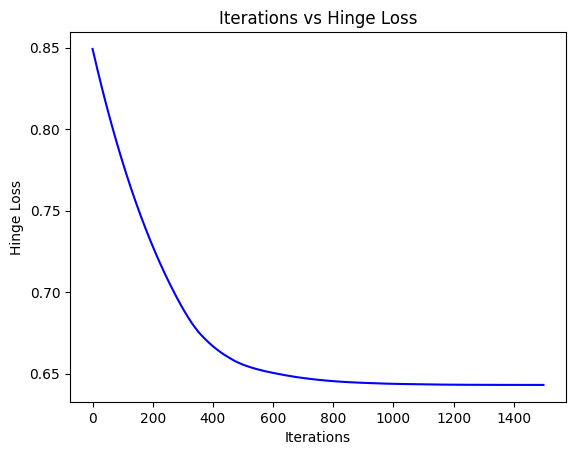

In [25]:
# Plotting loss vs iterations
plt.plot(range(num_iterations), loss_history, 'b-')
plt.xlabel("Iterations")
plt.ylabel("Hinge Loss")
plt.title("Iterations vs Hinge Loss")
plt.show()

In [26]:
# Predictions and evaluation
train_predictions = predict_svm(X_train, weights)
test_predictions = predict_svm(X_test, weights)

train_accuracy = np.mean(train_predictions == y_train) * 100
test_accuracy = np.mean(test_predictions == y_test) * 100

print(f"Training Accuracy: {train_accuracy}%")
print(f"Test Accuracy: {test_accuracy}%")

Training Accuracy: 77.72108843537416%
Test Accuracy: 82.43243243243244%


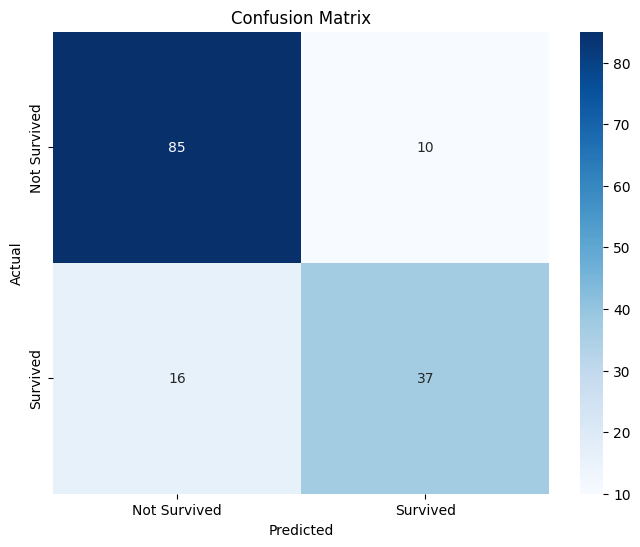

In [27]:
# Confusion Matrix
TP = np.sum((test_predictions == 1) & (y_test == 1))
TN = np.sum((test_predictions == 0) & (y_test == 0))
FP = np.sum((test_predictions == 1) & (y_test == 0))
FN = np.sum((test_predictions == 0) & (y_test == 1))

conf_matrix = np.array([[TN, FP], [FN, TP]])

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Survived', 'Survived'], yticklabels=['Not Survived', 'Survived'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [28]:
precision = TP / (TP + FP) if (TP + FP) > 0 else 0
recall = TP / (TP + FN) if (TP + FN) > 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

print(f"\nPrecision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1_score}")


Precision: 0.7872340425531915
Recall: 0.6981132075471698
F1 Score: 0.74
